# Bulldozer Sale Price Prediction

A machine learning project to predict the future sale price of bulldozers at auction based on their characteristics and historical data.

## Problem Definition

**Objective:** How well can we predict the future sale price of a bulldozer, given its characteristics and previous sale prices?

This is a regression problem where we aim to estimate the continuous value (sale price) of heavy equipment at auction.


## Dataset Description

The dataset is split into three files covering different time periods:

| File | Description | Time Period |
|------|-------------|-------------|
| **Train.csv** | Training set for model development | Data through end of 2011 |
| **Valid.csv** | Validation set for model tuning | January 1, 2012 - April 30, 2012 |
| **Test.csv** | Test set for final evaluation | May 1, 2012 - November 2012 |


## Evaluation Metric

**Root Mean Squared Logarithmic Error (RMSLE)**

This metric is particularly suitable for this problem because:
- Penalizes underestimation more than overestimation
- Handles the large range of sale prices effectively
- Focuses on relative differences rather than absolute differences



In [3]:
# # Timestamp
# import datetime

# print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Loading the Train data

In [5]:
train_url = "https://media.githubusercontent.com/media/jhlopesalves/classic_workflows/refs/heads/main/supervised_learning/regression/bulldozer/data/Train.csv"
train = pd.read_csv(train_url, low_memory=False, parse_dates=["saledate"])

### Building the Data Dictionary Class

In [ ]:
dictionary_url = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/refs/heads/main/supervised_learning/regression/bulldozer/data/Data%20Dictionary.xlsx%20-%20Data%20Dictionary.csv"


class DataDictionary:
	def __init__(self, csv_url):
		df = pd.read_csv(csv_url)
		# Create attributes dynamically
		for _, row in df.iterrows():
			# Extract and clean the variable name and description
			var_name = row["Variable"].strip()
			description = row["Description"].strip()
			# Dynamically create an attribute on self:
			setattr(self, var_name, description)

	def __repr__(self):
		return f"DataDictionary with {len(self.__dict__)} variables"


data_dict = DataDictionary(dictionary_url)

### Basic EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [8]:
train.isna().sum().sort_values(ascending=False)

,0
Pushblock,375906
Tip_Control,375906
Enclosure_Type,375906
Engine_Horsepower,375906
Blade_Extension,375906
Blade_Width,375906
Scarifier,375895
Grouser_Tracks,357763
Hydraulics_Flow,357763
Coupler_System,357667


In [9]:
train_raw = train.copy()
train_eda = train.copy()

In [10]:
sns.set_color_codes("bright")

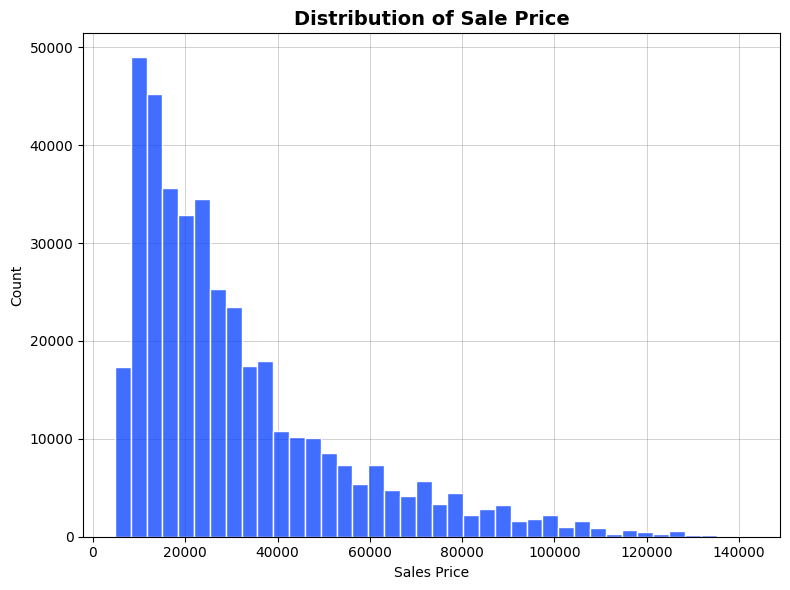

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(train_eda.SalePrice, color="b", edgecolor="white", ax=ax, bins=40)
ax.set(xlabel="Sales Price", ylabel="Count")
ax.set_title("Distribution of Sale Price", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class DatetimeFeatureExtractor(BaseEstimator, TransformerMixin):
	"""
	Extract temporal features from datetime columns.

	Parameters
	----------
	datetime_columns : list of str
	        Columns containing datetime values.
	features : list of str
	        Features to extract: 'saleYear', 'saleMonth', 'saleDay',
	        'saleDayofweek', 'saleDayofyear'.
	drop_original : bool, default=True
	        Whether to drop original datetime columns.
	"""

	def __init__(self, datetime_columns: list, features=None, drop_original: bool = True):
		# Fail early: validate inputs
		if not isinstance(datetime_columns, list):
			raise TypeError(f"datetime_columns must be a list, got {type(datetime_columns).__name__}")
		if not datetime_columns:
			raise ValueError("datetime_columns cannot be empty")
		if not all(isinstance(col, str) for col in datetime_columns):
			raise TypeError("All items in datetime_columns must be strings")

		self.datetime_columns = datetime_columns
		self.features = features or ["SaleYear", "SaleMonth", "SaleDay", "SaleDayofWeek", "SaleDayofYear"]

		# Validate features
		valid_features = {"SaleYear", "SaleMonth", "SaleDay", "SaleDayofWeek", "SaleDayofYear"}
		invalid_features = set(self.features) - valid_features
		if invalid_features:
			raise ValueError(f"Invalid features: {invalid_features}. Valid options: {valid_features}")

		self.drop_original = drop_original

	def fit(self, X, y=None):
		# Fail early: validate input data
		if X is None:
			raise ValueError("X cannot be None")
		if not isinstance(X, pd.DataFrame):
			raise TypeError(f"X must be a pandas DataFrame, got {type(X).__name__}")

		# Check if datetime columns exist
		missing_cols = set(self.datetime_columns) - set(X.columns)
		if missing_cols:
			raise ValueError(f"Datetime columns not found in DataFrame: {missing_cols}")

		return self

	def transform(self, X):
		# Safety check: validate input
		if X is None:
			raise ValueError("X cannot be None")
		if not isinstance(X, pd.DataFrame):
			raise TypeError(f"X must be a pandas DataFrame, got {type(X).__name__}")

		X = X.copy()

		for col in self.datetime_columns:
			if col not in X.columns:
				raise ValueError(f"Column '{col}' not found in DataFrame during transform")

			# Safety check: try to convert to datetime
			try:
				dt = pd.to_datetime(X[col], errors="coerce")
			except Exception as e:
				raise ValueError(f"Failed to convert column '{col}' to datetime: {str(e)}")

			# Check for NaT values after conversion
			nat_count = dt.isna().sum()
			if nat_count > 0:
				print(f"Warning: {nat_count} NaT values found in '{col}' after datetime conversion")

			feature_map = {
				"SaleYear": dt.dt.year,
				"SaleMonth": dt.dt.month,
				"SaleDay": dt.dt.day,
				"SaleDayofWeek": dt.dt.dayofweek,
				"SaleDayofYear": dt.dt.dayofyear,
			}

			for feat in self.features:
				if feat in feature_map:
					X[feat] = feature_map[feat]

			if self.drop_original:
				X = X.drop(columns=[col])

		return X

In [ ]:
from sklearn.pipeline import Pipeline

date_transform = Pipeline(steps=[("date_extractor", DatetimeFeatureExtractor(datetime_columns=["saledate"], drop_original=False))])

In [14]:
train_eda = date_transform.fit_transform(train_eda)

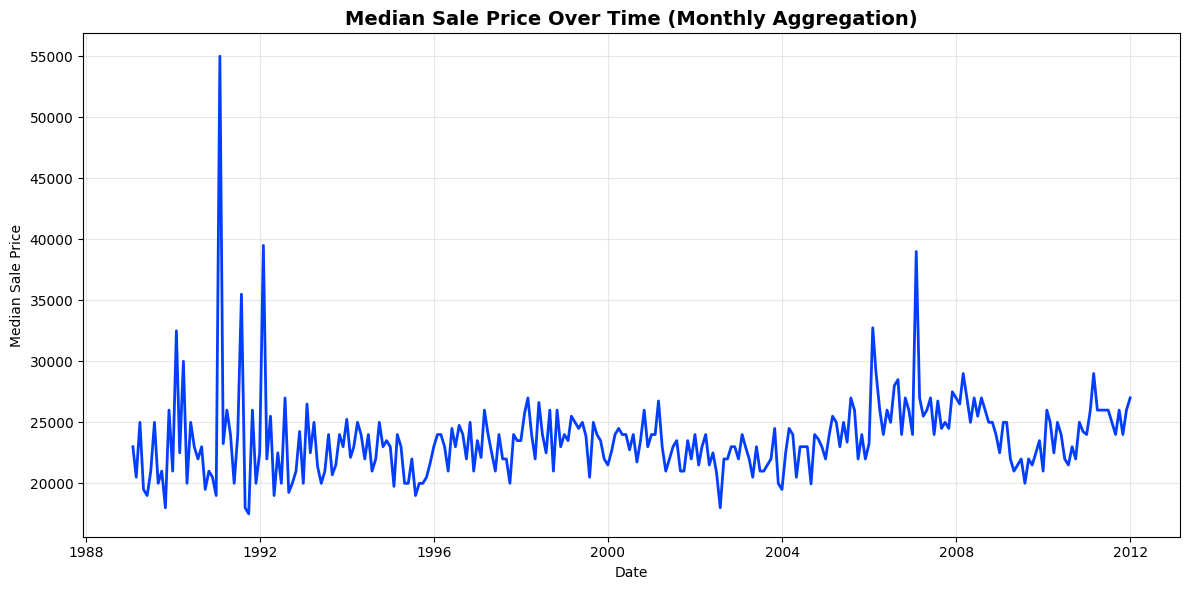

In [15]:
# Sort by date for proper time-series plotting
train_eda = train_eda.sort_values("saledate")

monthly_prices = train_eda.set_index("saledate")["SalePrice"].resample("ME").median()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=monthly_prices.index, y=monthly_prices, color="b", linewidth=2)

ax.set_title("Median Sale Price Over Time (Monthly Aggregation)", fontsize=14, fontweight="bold")
ax.set_ylabel("Median Sale Price")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

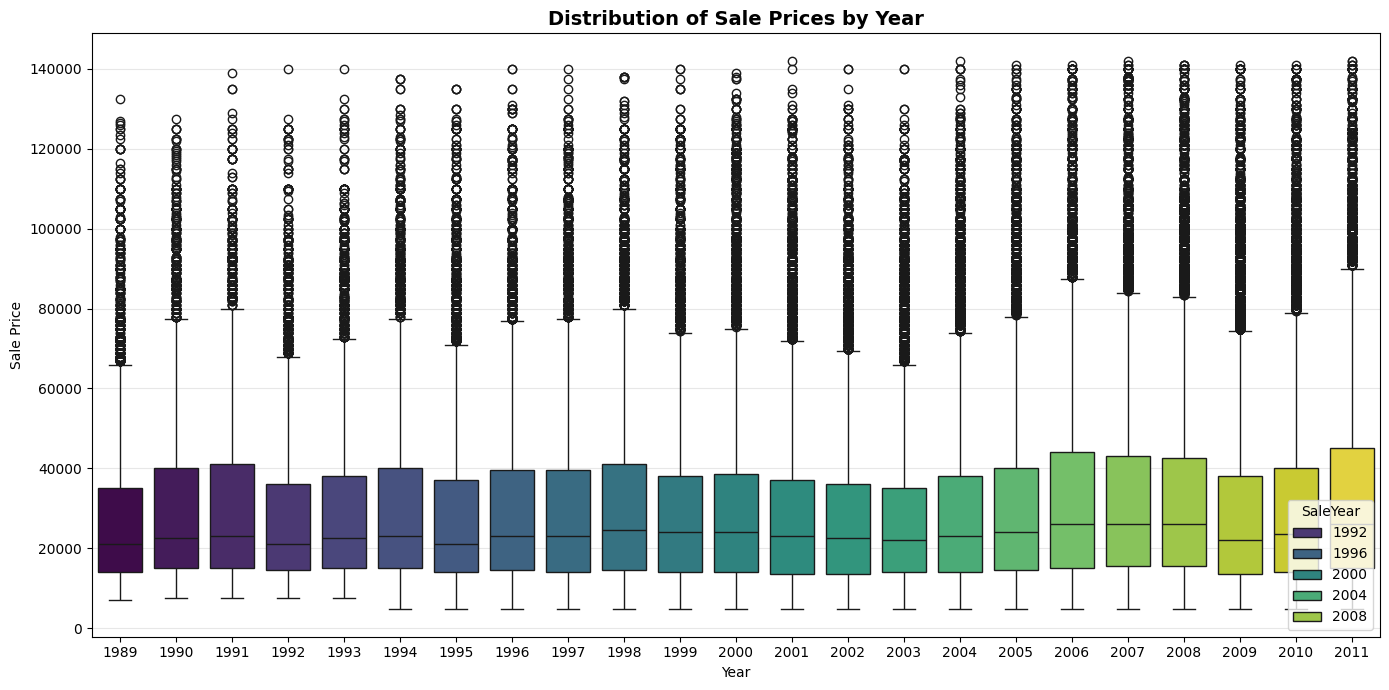

In [16]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.boxplot(data=train_eda, x="SaleYear", y="SalePrice", ax=ax, palette="viridis", hue="SaleYear")

ax.set_title("Distribution of Sale Prices by Year", fontsize=14, fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Sale Price")
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 400217
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

### Convert string to categories

One way  we can turn all of our data into numbers is by converting them into pandas categories.

In [ ]:
n_object_cols = 0
for label, content in train_eda.items():
	if pd.api.types.is_object_dtype(content):
		column_datatype = train_eda[label].dtype.name

		example_value = content.sample(1).values
		example_value_dtype = pd.api.types.infer_dtype(example_value)
		print(f"Col: {label} | dtype: {column_datatype} | Example: {example_value} | Example dtype: {example_value_dtype}")

		n_object_cols += 1

print(f"Total number of object columns: {n_object_cols}")

In [ ]:
# This will turn all of the object columns into category values
for label, content in train_eda.items():
	if pd.api.types.is_object_dtype(content):
		train_eda[label] = train_eda[label].astype("category")

In [20]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 400217
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   category      
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  category      
 11  fiBaseModel               401125 non-null  category      
 12  fi

### Filling missing numerical values

In [21]:
train_eda.select_dtypes("number").isna().sum().sort_values(ascending=False)

,0
MachineHoursCurrentMeter,258360
auctioneerID,20136
MachineID,0
SalePrice,0
SalesID,0
datasource,0
ModelID,0
YearMade,0
SaleYear,0
SaleMonth,0


### Discussing possible ways to handle missing values

For missing numeric values, some potential options are:

| **Method** | **Pros**  | **Cons** |
|-----|-----|-----|
| **Fill with mean of column** | - Easy to calculate/implement <br> - Retains overall data distribution | - Averages out variation <br> - Affected by outliers (e.g. if one value is much higher/lower than others) |
| **Fill with median of column** | - Easy to calculate/implement <br> - Robust to outliers <br> - Preserves center of data  | - Ignores data distribution shape |
| **Fill with mode of column** | - Easy to calculate/implement <br> - More useful for categorical-like data | - May not make sense for continuous/numerical data  |
| **Fill with 0 (or another constant)** | - Simple to implement <br> - Useful in certain contexts like counts  | - Introduces bias (e.g. if 0 was a value that meant something) <br> - Skews data (e.g. if many missing values, replacing all with 0 makes it look like that's the most common value)  |
| **Forward/Backward fill (use previous/future values to fill future/previous values)**  | - Maintains temporal continuity (for time series) | - Assumes data is continuous, which may not be valid |
| **Use a calculation from other columns** | - Takes existing information and reinterprets it | - Can result in unlikely outputs if calculations are not continuous | 
| **Interpolate  (e.g. like dragging a cell in Excel/Google Sheets)** | - Captures trends <br> - Suitable for ordered data | - Can introduce errors <br> - May assume linearity (data continues in a straight line) |
| **Drop missing values** | - Ensures complete data (only use samples with all information) <br> - Useful for small datasets | - Can result in data loss (e.g. if many missing values are scattered across columns, data size can be dramatically reduced) <br> - Reduces dataset size  |




### Imputing the missing values with the median of the column

In [27]:
from sklearn.impute import SimpleImputer

# Select only numerical columns for imputation
numerical_cols = train_eda.select_dtypes(include=[np.number]).columns

median_imputer = SimpleImputer(missing_values=np.nan, strategy="median", add_indicator=True)

numerical_imputed = median_imputer.fit_transform(train_eda[numerical_cols])

# Create a DataFrame for the imputed numerical data (including indicator columns)
# The imputer adds indicator columns for each column that had missing values
imputed_df = pd.DataFrame(numerical_imputed, columns=median_imputer.get_feature_names_out(numerical_cols), index=train_eda.index)

# Update the original DataFrame with the imputed numerical columns
train_eda[numerical_cols] = imputed_df[numerical_cols]

# Add the indicator columns to the DataFrame
indicator_cols = [col for col in imputed_df.columns if col not in numerical_cols]
train_eda[indicator_cols] = imputed_df[indicator_cols]

In [29]:
display(train_eda)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Travel_Controls,Differential_Type,Steering_Controls,SaleYear,SaleMonth,SaleDay,SaleDayofWeek,SaleDayofYear,missingindicator_auctioneerID,missingindicator_MachineHoursCurrentMeter
205615,1646770.0,9500.0,1126363.0,8434.0,132.0,18.0,1974.0,0.0,NaN,1989-01-17,...,None or Unspecified,NaN,NaN,1989.0,1.0,17.0,1.0,17.0,0.0,1.0
92803,1404019.0,24000.0,1169900.0,7110.0,132.0,99.0,1986.0,0.0,NaN,1989-01-31,...,NaN,NaN,NaN,1989.0,1.0,31.0,1.0,31.0,0.0,1.0
98346,1415646.0,35000.0,1262088.0,3357.0,132.0,99.0,1975.0,0.0,NaN,1989-01-31,...,NaN,NaN,NaN,1989.0,1.0,31.0,1.0,31.0,0.0,1.0
169297,1596358.0,19000.0,1433229.0,8247.0,132.0,99.0,1978.0,0.0,NaN,1989-01-31,...,NaN,Standard,Conventional,1989.0,1.0,31.0,1.0,31.0,0.0,1.0
274835,1821514.0,14000.0,1194089.0,10150.0,132.0,99.0,1980.0,0.0,NaN,1989-01-31,...,NaN,Standard,Conventional,1989.0,1.0,31.0,1.0,31.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393123,6260878.0,13500.0,1799594.0,4102.0,149.0,2.0,1000.0,0.0,NaN,2011-12-30,...,None or Unspecified,NaN,NaN,2011.0,12.0,30.0,4.0,364.0,0.0,1.0
397987,6288376.0,9750.0,1872596.0,4875.0,149.0,2.0,1000.0,0.0,NaN,2011-12-30,...,NaN,Standard,Conventional,2011.0,12.0,30.0,4.0,364.0,0.0,1.0
392664,6258093.0,14500.0,1877553.0,3170.0,149.0,2.0,1988.0,0.0,NaN,2011-12-30,...,NaN,NaN,NaN,2011.0,12.0,30.0,4.0,364.0,0.0,1.0
400458,6315563.0,12500.0,1869637.0,26456.0,149.0,2.0,2010.0,0.0,NaN,2011-12-30,...,NaN,Standard,Conventional,2011.0,12.0,30.0,4.0,364.0,0.0,1.0


In [30]:
train_eda.isna().sum().sort_values(ascending=False)

,0
Engine_Horsepower,375906
Enclosure_Type,375906
Blade_Width,375906
Blade_Extension,375906
Tip_Control,375906
Pushblock,375906
Scarifier,375895
Grouser_Tracks,357763
Hydraulics_Flow,357763
Coupler_System,357667


### Filling and turning categorical variables into numbers 

In [ ]:
# Turn categorical variables into numbers and fill missing
for label, content in train_eda.items():
	if not pd.api.types.is_numeric_dtype(content):
		# Add binary column to indicate whether sample had missing values 
		train_eda[f"{label}_is_missing"] = pd.isna(content)
		# Turn categorieds into numbers and add +1
		train_eda[label] = pd.Categorical(content).codes + 1

In [36]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 400217
Columns: 105 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(45), float64(15), int16(5), int8(40)
memory usage: 85.3 MB


In [37]:
train_eda.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770.0,9500.0,1126363.0,8434.0,132.0,18.0,1974.0,0.0,0,1,...,True,True,True,True,True,False,False,False,True,True
92803,1404019.0,24000.0,1169900.0,7110.0,132.0,99.0,1986.0,0.0,0,2,...,True,True,True,True,True,True,True,True,True,True
98346,1415646.0,35000.0,1262088.0,3357.0,132.0,99.0,1975.0,0.0,0,2,...,True,True,True,True,True,True,True,True,True,True
169297,1596358.0,19000.0,1433229.0,8247.0,132.0,99.0,1978.0,0.0,0,2,...,True,True,True,True,True,True,True,True,False,False
274835,1821514.0,14000.0,1194089.0,10150.0,132.0,99.0,1980.0,0.0,0,2,...,True,True,True,True,True,True,True,True,False,False


In [38]:
train_eda.isna().sum().sort_values(ascending=False)

,0
SalesID,0
SalePrice,0
MachineID,0
ModelID,0
datasource,0
...,...
Backhoe_Mounting_is_missing,0
Blade_Type_is_missing,0
Travel_Controls_is_missing,0
Differential_Type_is_missing,0


In [40]:
%%time
from sklearn.ensemble import RandomForestRegressor

X = train_eda.drop("SalePrice", axis=1)
y = train_eda["SalePrice"]
# Instantiate the RF model
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)
# Fit the model
rf_model.fit(X, y)

CPU times: user 24min 49s, sys: 3.22 s, total: 24min 52s
Wall time: 3min 19s


RandomForestRegressor(n_jobs=-1, random_state=42)

### Loading the Test data to make predictions

In [41]:
rf_model.score(X, y)

0.9878524539667796

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from transformers import Pipeline


def feature_engineering_pipe(*, custom_transformer, date_time_cols: list, drop_original: bool = True):
	return Pipeline(
		steps=[
			("year_extractor", custom_transformer),
		]
	)


def make_numerical_pipe(*, transformer: TransformerMixin | None = None) -> Pipeline:
	if not isinstance(transformer, BaseEstimator):
		raise TypeError(f"Expected 'transformer' to be a BaseEstimator, got {type(transformer).__name__}")
	return Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])


def make_categorical_pipe(*, transformer: TransformerMixin | None = None, drop_first: bool = True, sparse_output: bool = False) -> Pipeline:
	return Pipeline(
		steps=[
			(f"{transformer}", transformer),
			("ordinal", OrdinalEncoder(categories="auto", handle_unknown="use_encoded_value", unknown_value=np.nan, encoded_missing_value=np.nan)),
		]
	)


def make_processor(
	*, custom_transformer: TransformerMixin, date_time_cols: list[str], categorical_cols: list[str], numerical_cols: list[str], drop_original: bool = True
) -> ColumnTransformer:
	transformers = [
		("feature_engineering", feature_engineering_pipe(custom_transformer=custom_transformer, date_time_cols=date_time_cols, drop_original=drop_original), date_time_cols),
		("categorical", make_categorical_pipe(transformer=SimpleImputer(strategy="most_frequent")), categorical_cols),
		("numerical", make_numerical_pipe(), numerical_cols),
	]
	return ColumnTransformer(transformers=transformers, remainder="drop")